In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Lectura de Dataset



In [4]:
# Dataset con el cual entrenaremos nuestro modelo

#Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola.
#Sobol Tensor Trains for Global Sensitivity Analysis.
#In arXiv Computer Science / Numerical Analysis e-prints, 2017
#(https://128.84.21.199/abs/1712.00233).

#Cedric Nugteren and Valeriu Codreanu. CLTune: A Generic Auto-Tuner for OpenCL Kernels.
#In: MCSoC: 9th International Symposium on Embedded Multicore/Many-core Systems-on-Chip. IEEE, 2015
#(http://ieeexplore.ieee.org/document/7328205/)

dataset = pd.read_csv('https://raw.githubusercontent.com/daneelsan/INF648-Project/main/dataset/sgemm_product.csv');
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


# Exploración de la data

In [5]:
#Cantidad de filas
dataset.shape

(241600, 18)

In [6]:
#Tipos de datos para cada columna
dataset.dtypes

MWG            int64
NWG            int64
KWG            int64
MDIMC          int64
NDIMC          int64
MDIMA          int64
NDIMB          int64
KWI            int64
VWM            int64
VWN            int64
STRM           int64
STRN           int64
SA             int64
SB             int64
Run1 (ms)    float64
Run2 (ms)    float64
Run3 (ms)    float64
Run4 (ms)    float64
dtype: object

In [8]:
#Valores estadísticos para cada columna
dataset.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


In [9]:
#Valores únicos de cada columna
dataset.nunique()

MWG              4
NWG              4
KWG              2
MDIMC            3
NDIMC            3
MDIMA            3
NDIMB            3
KWI              2
VWM              4
VWN              4
STRM             2
STRN             2
SA               2
SB               2
Run1 (ms)    58161
Run2 (ms)    58269
Run3 (ms)    58264
Run4 (ms)    58154
dtype: int64

In [10]:
# Existencia de valores nulos para cada columna
dataset.isnull().any()

MWG          False
NWG          False
KWG          False
MDIMC        False
NDIMC        False
MDIMA        False
NDIMB        False
KWI          False
VWM          False
VWN          False
STRM         False
STRN         False
SA           False
SB           False
Run1 (ms)    False
Run2 (ms)    False
Run3 (ms)    False
Run4 (ms)    False
dtype: bool

In [19]:
def graph_dist_column(col):
  print(dataset[col].sort_values(ascending=True).value_counts(sort = False))
  plt.figure(figsize=(10, 6))
  plt.hist(dataset[col], bins=100, color='lightgreen', edgecolor='black')
  plt.title('Distribution of ' + col)
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

MWG
16     18944
32     47264
64     75584
128    99808
Name: count, dtype: int64


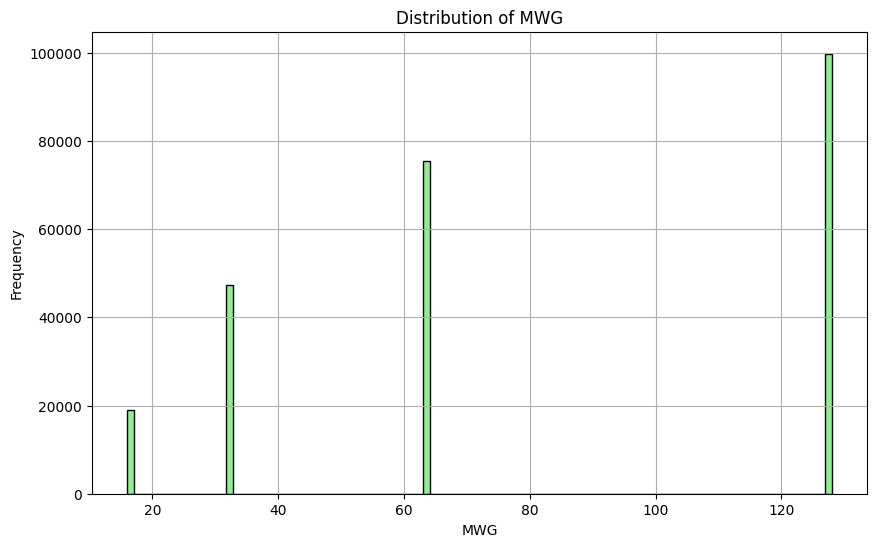

NWG
16     18944
32     47264
64     75584
128    99808
Name: count, dtype: int64


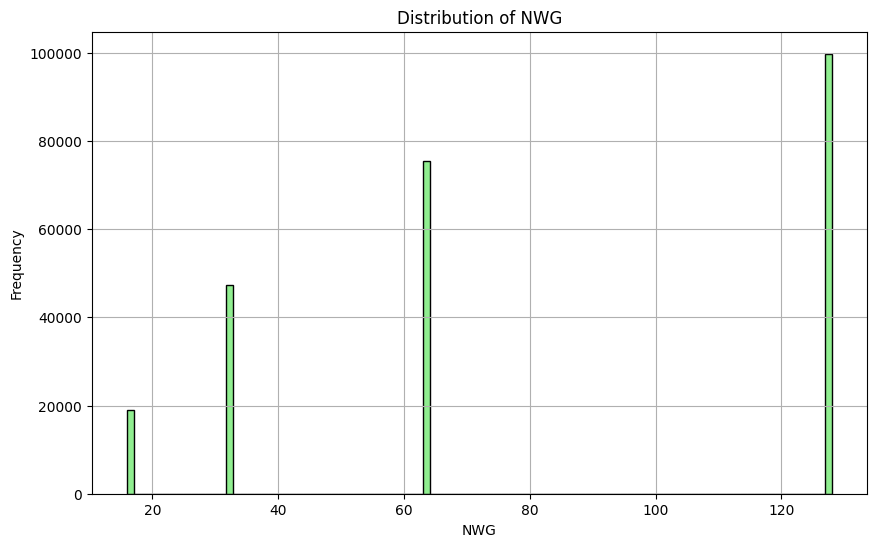

In [21]:
#Se evalúan los valores numéricos con desviación estándar muy alta
graph_dist_column('MWG')
graph_dist_column('NWG')